In [1]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'fastscnn_hyperparameters_tuning__refactoring'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
Cloning into 'deep-seasonal-color-analysis-system'...
remote: Enumerating objects: 642, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 642 (delta 27), reused 33 (delta 13), pack-reused 519
Receiving objects: 100% (642/642), 81.31 MiB | 38.67 MiB/s, done.
Resolving deltas: 100% (346/346), done.
/content/deep-seasonal-color-analysis-system
Branch 'main__fastscnn_hyperparameters_tuning' set up to track remote branch 'main__fastscnn_hyperparameters_tuning' from 'origin'.
Switched to a new branch 'main__fastscnn_hyperparameters_tuning'
From https://github.com/mrcmich/deep-seasonal-color-analysis-system
 * branch            main__fastscnn_hyperparameters_tuning -> FETCH_HEAD
Already up to date.


In [2]:
import torch
from torch import nn
from torchvision import ops
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.cloud.UNet import unet
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing
import torchsummary
from models import config

try:
  executing_on_colab
except NameError:
  executing_on_colab = False
  weights_path = config.WEIGHTS_PATH
  dataset_path = config.DATASET_PATH

In [4]:
# defining transforms
tH, tW = 256, 256
image_transform = T.Compose([T.Resize((tH, tW)), T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])
target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
X_train, X_test, Y_train, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.MyDataset(X_train, Y_train, image_transform, target_transform)
test_dataset = dataset.MyDataset(X_test, Y_test, image_transform, target_transform)

# setting up model and fixed (initially) hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 10
batch_size = 32
score_fn = metrics.batch_mIoU
learning_rate = 0.01
class_weights = torch.tensor(config.CLASS_WEIGHTS)

In [5]:
# === selecting best loss function ===

results = []

loss_fn_candidates = [
    nn.CrossEntropyLoss(),
    nn.CrossEntropyLoss(weight=class_weights.to(device))]

for loss_fn in loss_fn_candidates:
    model = unet.UNet(out_channels=n_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    partial_results = training_and_testing.train_model(
        device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
        lr_scheduler=None, verbose=True, evaluate=True)
    results.append(partial_results)

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.6964594736228301, average_train_score: 0.366643488407135
average_val_loss: 0.6656100570209442, average_val_score: 0.36641255021095276
--- Epoch 2/10 ---
average_train_loss: 0.5572682748153339, average_train_score: 0.3964506685733795
average_val_loss: 0.5321139395236969, average_val_score: 0.39514487981796265
--- Epoch 3/10 ---
average_train_loss: 0.45174316896332634, average_train_score: 0.3935796022415161
average_val_loss: 0.4171182849104442, average_val_score: 0.36683231592178345
--- Epoch 4/10 ---
average_train_loss: 0.3661150196593711, average_train_score: 0.4038794934749603
average_val_loss: 0.33477152907659136, average_val_score: 0.4126862585544586
--- Epoch 5/10 ---
average_train_loss: 0.2994109322967013, average_train_score: 0.43679144978523254
average_val_loss: 0.28923593414208243, average_val_score: 0.44662508368492126
--- Epoch 6/10 ---
average_train_loss: 0.2561040282928706, average_train_score: 0.4681355059146881
avera

training score after 10 epochs: 0.593682587146759
validation score after 10 epochs: 0.6081812381744385


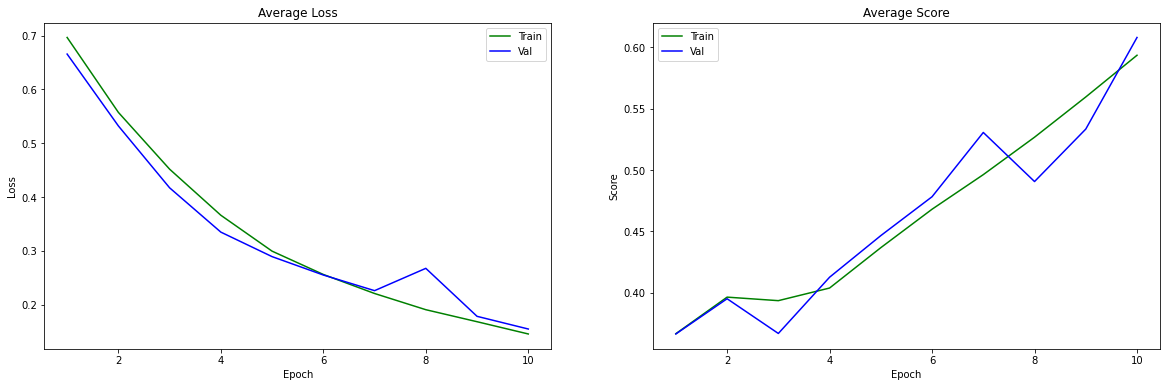

In [6]:
# Cross Entropy Loss
last_train_score = results[0]['average_train_score'][-1]
last_val_score = results[0]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[0], plotsize=(20, 6))

training score after 10 epochs: 0.6517609357833862
validation score after 10 epochs: 0.6622998118400574


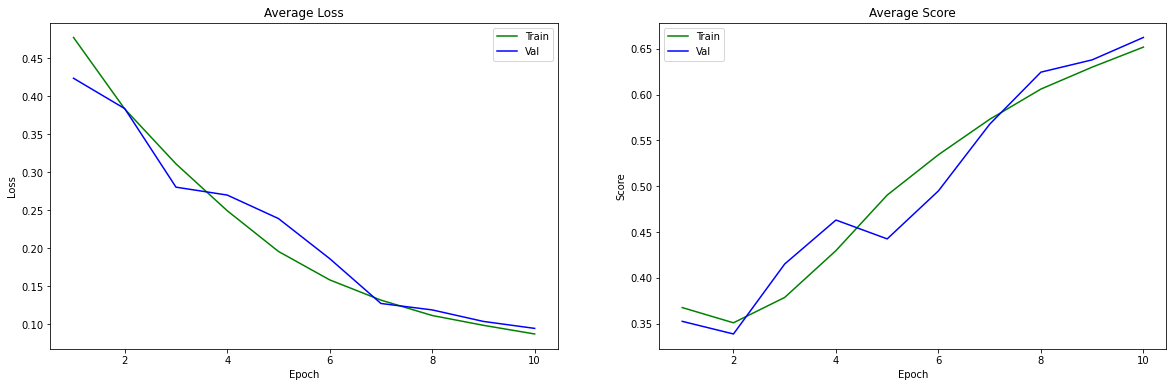

In [7]:
# Weighted Cross Entropy Loss
last_train_score = results[1]['average_train_score'][-1]
last_val_score = results[1]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[1], plotsize=(20, 6))

In [8]:
# === selecting best optimizer ===

results = []
loss_fn = nn.CrossEntropyLoss()

models = [
    unet.UNet(out_channels=n_classes),
    unet.UNet(out_channels=n_classes),
    unet.UNet(out_channels=n_classes),
]

optimizer_candidates = [
    torch.optim.SGD(models[0].parameters(), lr=learning_rate),
    torch.optim.Adam(models[1].parameters(), lr=learning_rate),
    torch.optim.AdamW(models[2].parameters(), lr=learning_rate)]

for i, optimizer in enumerate(optimizer_candidates):
    model = models[i]
    partial_results = training_and_testing.train_model(
        device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
        lr_scheduler=None, verbose=True, evaluate=True)
    results.append(partial_results)

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.9985341118951129, average_train_score: 0.31850317120552063
average_val_loss: 0.7476527302984207, average_val_score: 0.34923481941223145
--- Epoch 2/10 ---
average_train_loss: 0.7068611086263955, average_train_score: 0.3607088327407837
average_val_loss: 0.6667843872592563, average_val_score: 0.3599751889705658
--- Epoch 3/10 ---
average_train_loss: 0.6283903274780664, average_train_score: 0.37944599986076355
average_val_loss: 0.6038269760116698, average_val_score: 0.3794821500778198
--- Epoch 4/10 ---
average_train_loss: 0.5497730099237882, average_train_score: 0.39526671171188354
average_val_loss: 0.5233967540756105, average_val_score: 0.3972261846065521
--- Epoch 5/10 ---
average_train_loss: 0.4874517617062626, average_train_score: 0.4072423279285431
average_val_loss: 0.4772173398070865, average_val_score: 0.40866267681121826
--- Epoch 6/10 ---
average_train_loss: 0.4404870067906176, average_train_score: 0.4162052571773529
average

training score after 10 epochs: 0.43398013710975647
validation score after 10 epochs: 0.4277198612689972


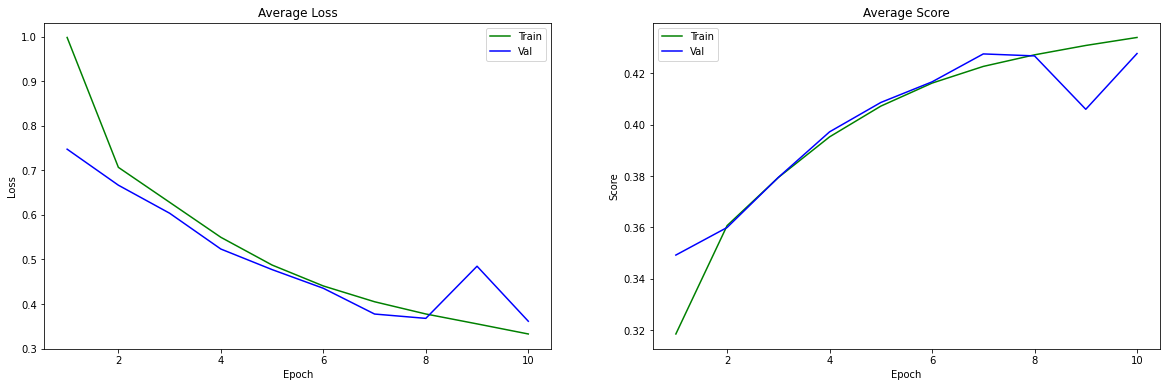

In [9]:
# SGD
last_train_score = results[0]['average_train_score'][-1]
last_val_score = results[0]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[0], plotsize=(20, 6))

training score after 10 epochs: 0.5785703659057617
validation score after 10 epochs: 0.5853235125541687


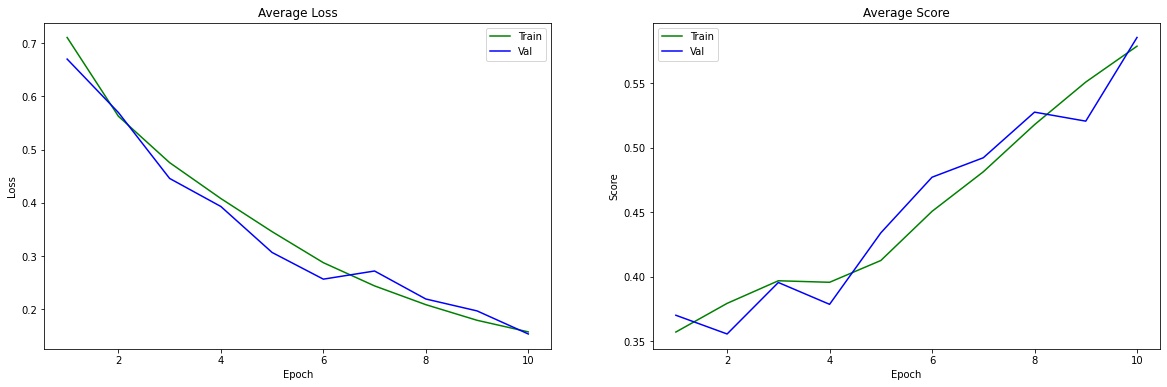

In [10]:
# Adam
last_train_score = results[1]['average_train_score'][-1]
last_val_score = results[1]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[1], plotsize=(20, 6))

training score after 10 epochs: 0.6162253022193909
validation score after 10 epochs: 0.5970306396484375


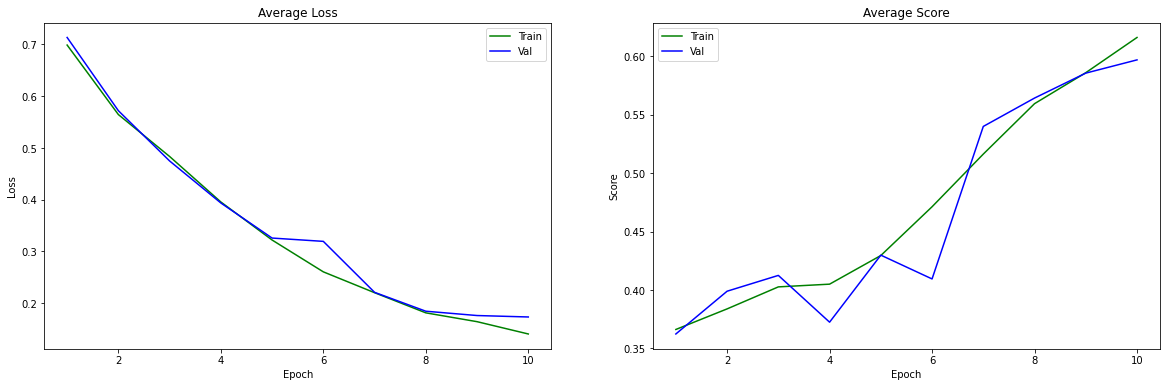

In [11]:
# AdamW
last_train_score = results[2]['average_train_score'][-1]
last_val_score = results[2]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[2], plotsize=(20, 6))

In [12]:
# === selecting best LR scheduler ===

models = [
    unet.UNet(out_channels=n_classes),
    unet.UNet(out_channels=n_classes),
    unet.UNet(out_channels=n_classes),
]

results = []
loss_fn = nn.CrossEntropyLoss()

optimizers = [
    torch.optim.Adam(models[0].parameters(), lr=learning_rate),
    torch.optim.Adam(models[1].parameters(), lr=learning_rate),
    torch.optim.Adam(models[2].parameters(), lr=learning_rate)]

scheduler_candidates = [
    None,
    torch.optim.lr_scheduler.LinearLR(optimizers[1], start_factor=0.05),
    torch.optim.lr_scheduler.ExponentialLR(optimizers[2], gamma=0.05)]

for i, scheduler in enumerate(scheduler_candidates):
    model = models[i]
    optimizer = optimizers[i]

    partial_results = training_and_testing.train_model(
        device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
        lr_scheduler=scheduler, verbose=True, evaluate=True)
    results.append(partial_results)

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.7278077653330616, average_train_score: 0.34768885374069214
average_val_loss: 0.7186205585797628, average_val_score: 0.3521418869495392
--- Epoch 2/10 ---
average_train_loss: 0.578315966744029, average_train_score: 0.37215134501457214
average_val_loss: 0.5492943071183705, average_val_score: 0.359441876411438
--- Epoch 3/10 ---
average_train_loss: 0.49056157045214943, average_train_score: 0.3805101215839386
average_val_loss: 0.4831089921413906, average_val_score: 0.39610257744789124
--- Epoch 4/10 ---
average_train_loss: 0.41144761948334185, average_train_score: 0.3887566030025482
average_val_loss: 0.46714230851521565, average_val_score: 0.38985759019851685
--- Epoch 5/10 ---
average_train_loss: 0.33221912914701335, average_train_score: 0.42448365688323975
average_val_loss: 0.31351662935718655, average_val_score: 0.4386040270328522
--- Epoch 6/10 ---
average_train_loss: 0.2711573153139859, average_train_score: 0.4636640250682831
aver

training score after 10 epochs: 0.6328128576278687
validation score after 10 epochs: 0.624880313873291


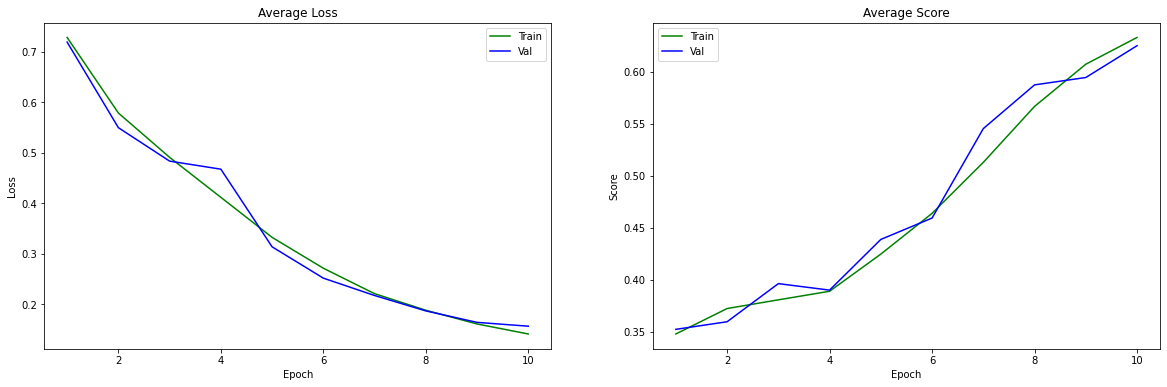

In [13]:
# no scheduler
last_train_score = results[0]['average_train_score'][-1]
last_val_score = results[0]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[0], plotsize=(20, 6))

training score after 10 epochs: 0.6999558806419373
validation score after 10 epochs: 0.705371081829071


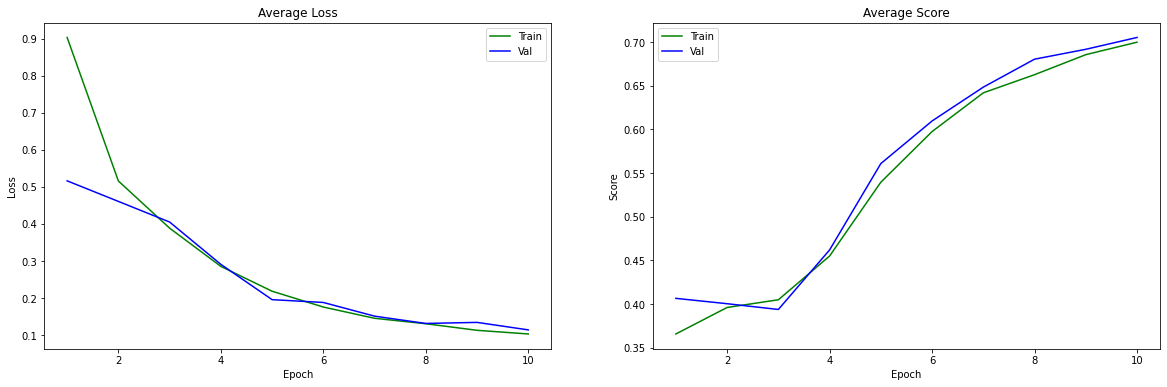

In [14]:
# linear scheduler
last_train_score = results[1]['average_train_score'][-1]
last_val_score = results[1]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[1], plotsize=(20, 6))

training score after 10 epochs: 0.3767254948616028
validation score after 10 epochs: 0.3767795264720917


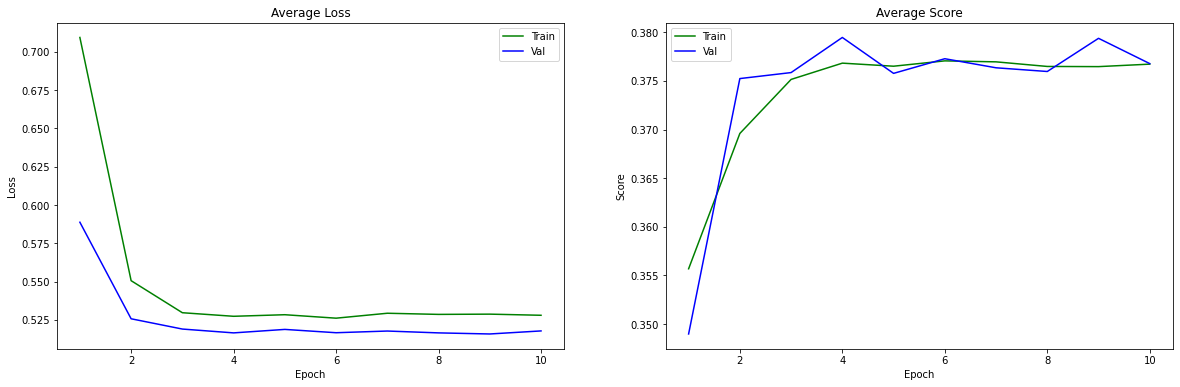

In [15]:
# exponential scheduler
last_train_score = results[2]['average_train_score'][-1]
last_val_score = results[2]['average_val_score'][-1]
print(f'training score after {n_epochs} epochs: {last_train_score}')
print(f'validation score after {n_epochs} epochs: {last_val_score}')
training_and_testing.plot_training_results(results[2], plotsize=(20, 6))